In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as gbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from pickle import dump, load

### Get data
After reading the file we see that there are a lot of nin numerical data. To train a machine learning model we need to process them and convert to numbers.

In [4]:
df = pd.read_csv("../par_listings.csv", index_col='id')
df.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

### Preprocessing
- We have a lot of unnecessary features, such as ids, urls and several others. We delete them
- Also, there are a lot of data that has to be converted from object to integer or float data type. For categorical features we can use one hot encoding
- Some numerical features such as host rating for example, are better to split into ordinary features. Because the majority of values are distributed around 90%, so we can split into four categories '0-49%', '50-89%', '90-99%', '100%' that indicate host rating range.

In [5]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [6]:
#delete unnecessary columns
columns = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'host_id',
           'description', 'name', 'neighborhood_overview', 'picture_url', 'host_acceptance_rate',
           'host_url', 'host_name', 'host_about', 'host_since',
           'host_thumbnail_url', 'host_picture_url',
           'host_neighbourhood', 'host_listings_count', 'host_verifications',
           'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_group_cleansed', 
        'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'host_location',
       'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
        'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'instant_bookable', 'has_availability', 
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
df.drop(columns, axis=1, inplace=True)
df.rename(columns={"neighbourhood_cleansed":"neighbourhood"}, inplace=True)

#delete non popular categories
df = df.groupby("property_type").filter(lambda x: len(x) > 100)
df = df.groupby("neighbourhood").filter(lambda x: len(x) > 100)

df.replace({'f': 0, 't': 1}, inplace=True)
# convert dtype to category
df.room_type = df.room_type.astype('category')
df.property_type = df.property_type.astype('category')
df.neighbourhood = df.neighbourhood.astype('category')

# convert from obj to float
df["bathrooms_text"].replace("Shared half-bath", "1 shared bath", inplace=True)
df["bathrooms_text"].replace("Private half-bath", "1 bath", inplace=True)
df["bathrooms_text"].replace("Half-bath", "1 bath", inplace=True)
df["bathrooms"] = df["bathrooms_text"].apply(lambda row: float(str(row).split(' ')[0]))
df.bathrooms.fillna(0, inplace=True)
df.drop(["bathrooms_text"], axis=1, inplace=True)

#convert target: price
df.price.replace(",", "", inplace=True, regex=True)
df.price = df.price.apply(lambda row: float(str(row)[1:]))
df.loc[df.price < 10, 'price'] = 10
df.loc[df.price > 1000, 'price'] = 1000

df.first_review = pd.to_datetime(df.first_review) # Converting to datetime
df.last_review = pd.to_datetime(df.last_review)
# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2023, 1, 2) - df.first_review).astype('timedelta64[D]')
df['time_since_last_review'] = (datetime(2023, 1, 2) - df.last_review).astype('timedelta64[D]')

df.host_response_time.fillna("unknown", inplace=True)
df.dropna(subset=['host_total_listings_count', 'beds'], inplace=True)
df.bathrooms.fillna(df['bathrooms'].median(), inplace=True)
df.bedrooms.fillna(df['bedrooms'].median(), inplace=True)
df.host_is_superhost.fillna(0, inplace=True)

df.property_type.replace({
    'Room in aparthotel': 'Room in hotel',
    'Private room in bed and breakfast': 'Room in hotel',
    'Private room in home': 'Private room in rental unit',
    'Private room in townhouse': 'Private room in rental unit',
    'Private room in loft': 'Private room in rental unit',
    'Entire serviced apartment': 'Entire rental unit',
    }, inplace=True)

bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

df.property_type.replace({
    'Room in aparthotel': 'Room in hotel',
    'Private room in bed and breakfast': 'Room in hotel',
    'Private room in home': 'Private room in rental unit',
    'Private room in townhouse': 'Private room in rental unit',
    'Private room in loft': 'Private room in rental unit',
    'Entire serviced apartment': 'Entire rental unit',
    }, inplace=True)

df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
df.host_response_rate = df.host_response_rate.astype('str')
df.host_response_rate.replace('nan', 'unknown', inplace=True)

df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:, 26:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:, 26:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)

df.drop(infrequent_amenities, axis=1, inplace=True)
df.drop('amenities', axis=1, inplace=True)
df.drop(columns=['first_review', "last_review"], inplace=True)

In [7]:
df.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_90',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'calculated_host_listings_count', 'time_since_first_review',
       'time_since_last_review', 'air_conditioning', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

### Encode categorical features
Here we will encode all categorical features using one hot encoding (or get dummies in pandas)

In [8]:
df_ = pd.get_dummies(df)
# df = pd.concat([df, onehot], axis=1)
# df.drop(columns=["room_type", "property_type", "neighbourhood", "amenities"], inplace=True)
# df.columns = df.columns.str.replace(" ", "_", regex=True)

List of columns after preprocessing:

In [9]:
df_.columns

Index(['host_is_superhost', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_90',
       'number_of_reviews', 'review_scores_accuracy',
       'calculated_host_listings_count', 'air_conditioning', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance', 'host_response_time_a few days or more',
       'host_response_time_unknown', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_response_rate_0-49%',
       'host_response_rate_100%', 'host_response_rate_50-89%',
       'host_response_rate_90-99%', 'host_response_rate_unknown',
       'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse',
       'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Mo

Before coming to model engineering, we need to estimate if we have any correlating features. We need to process them somehow to avoid collinearity.

In [18]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(100, 10, as_cmap=True)
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                center=0, 
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5}, 
                vmax=corr[corr != 1.0].max().max());

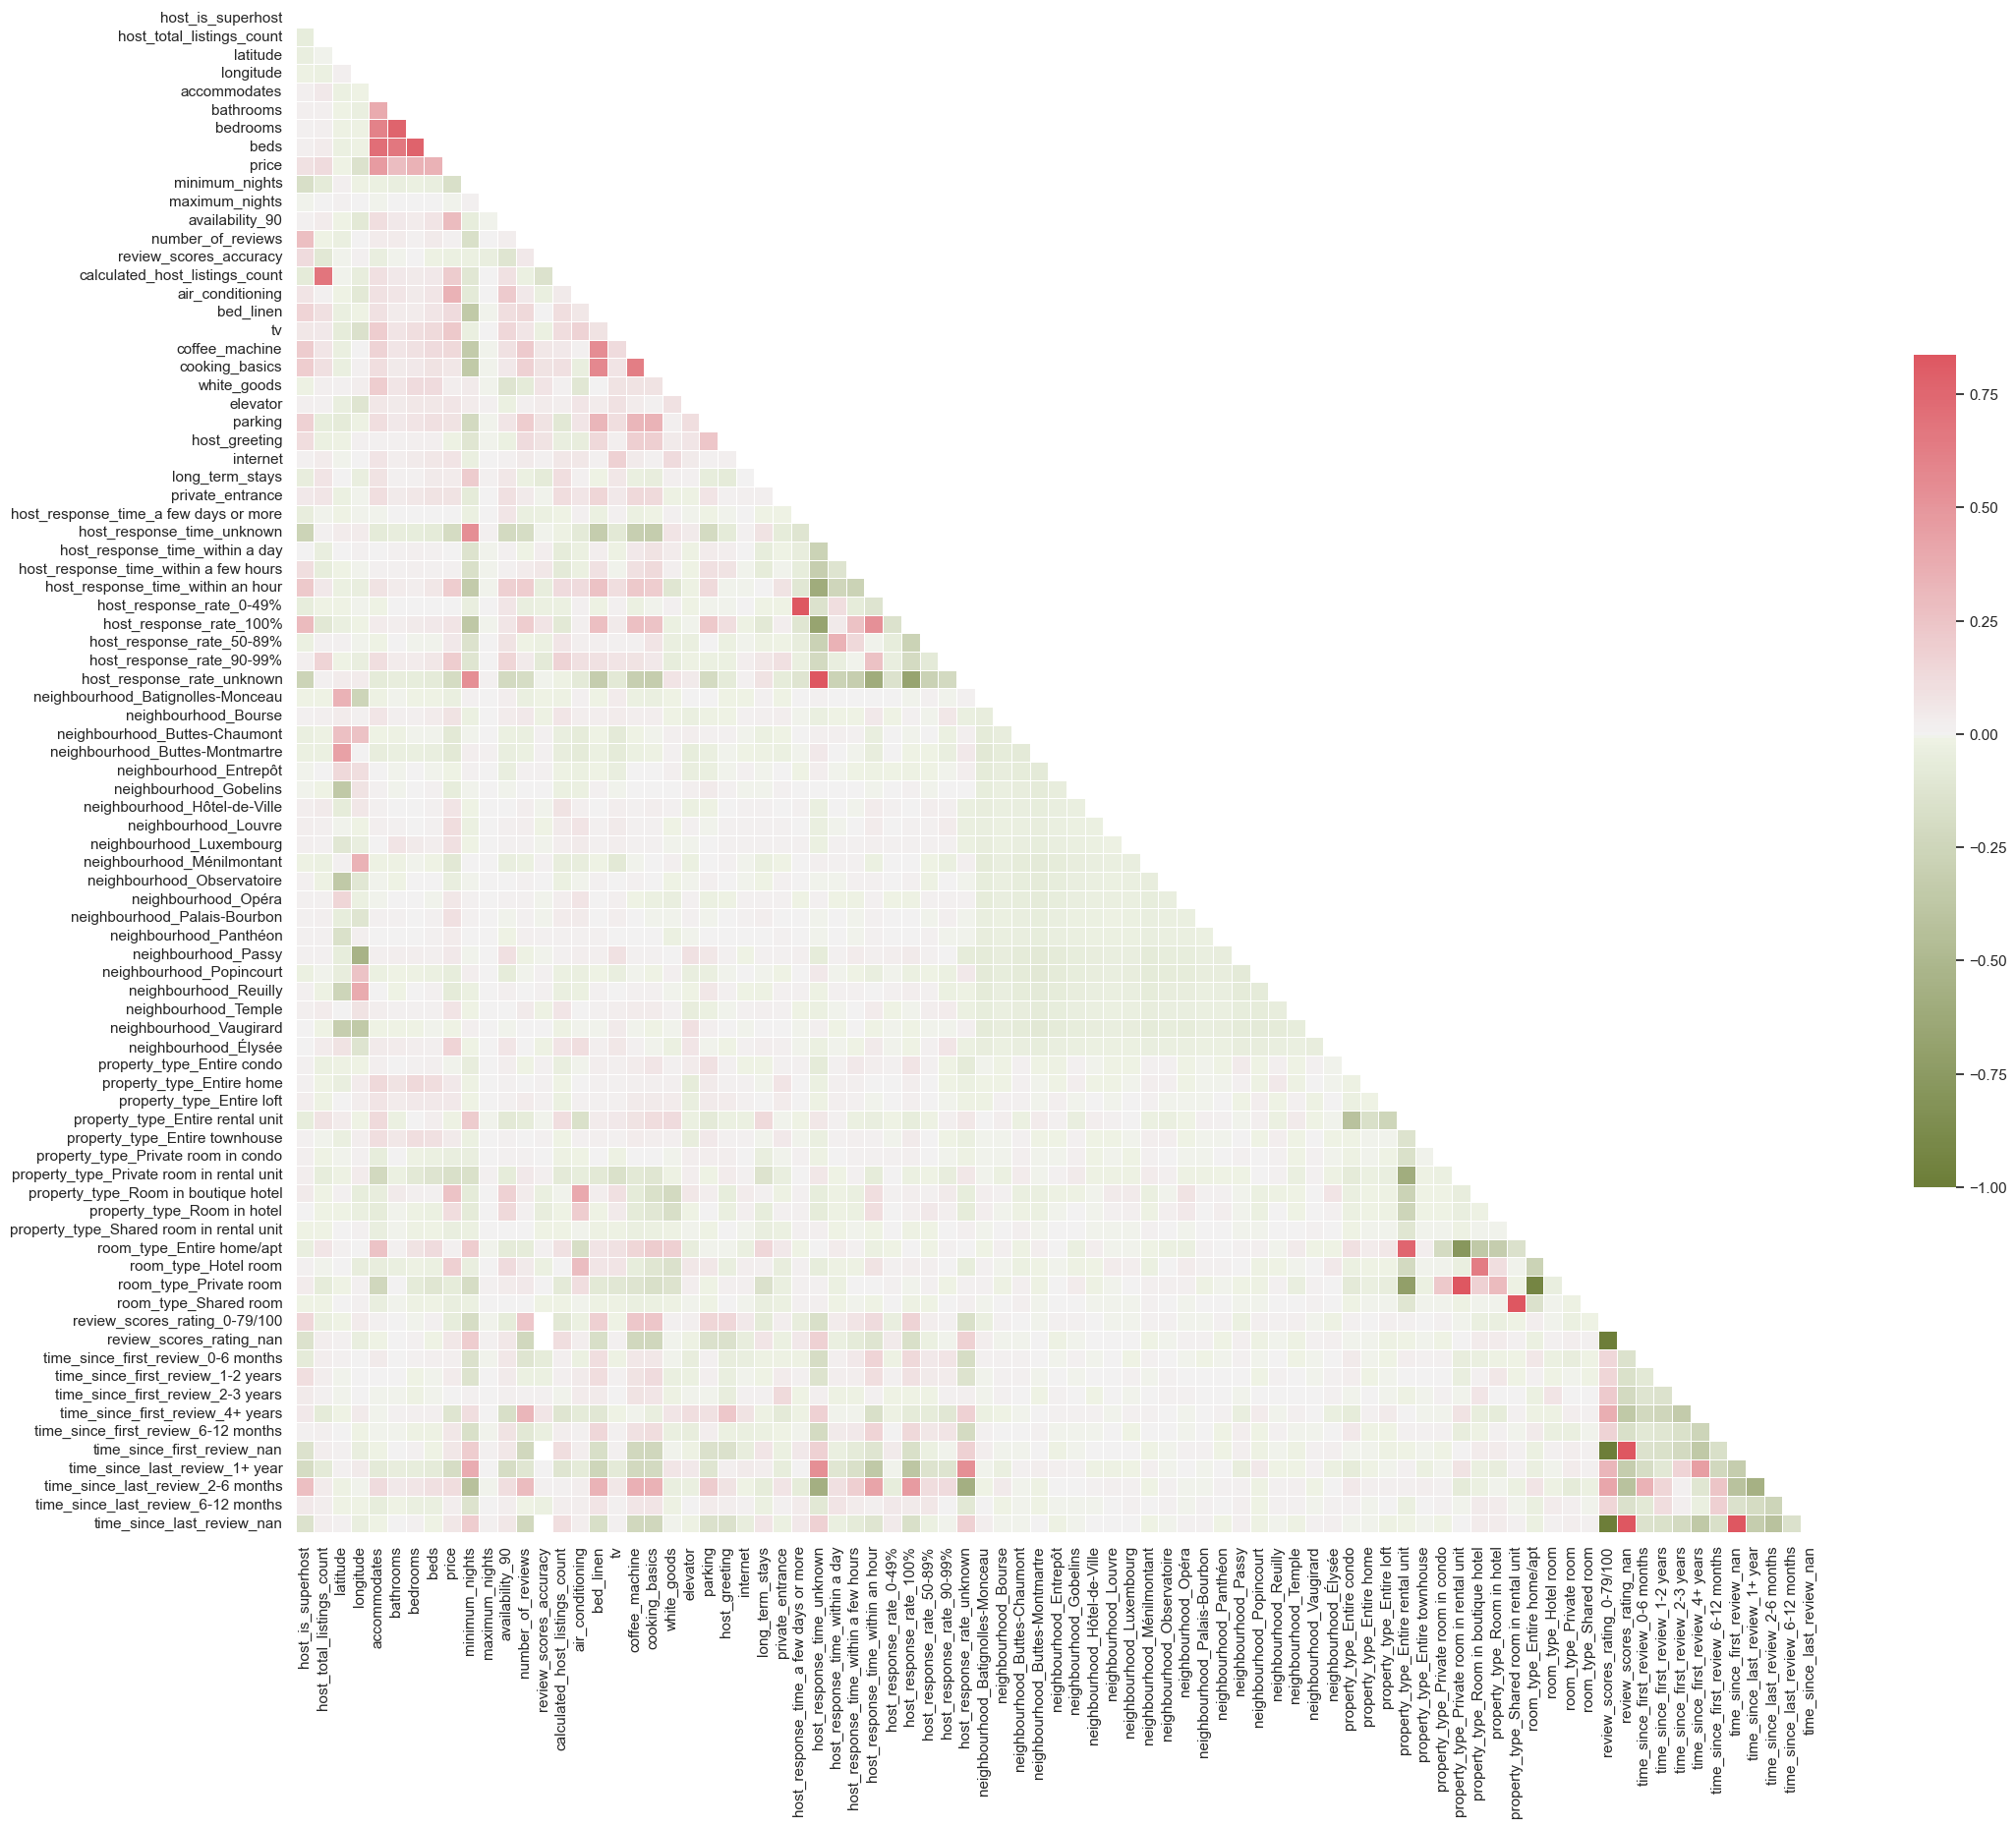

In [23]:
multi_collinearity_heatmap(df_, figsize=(25, 22))

- It is very logical that district correlates with latitude and longitude
- It is very logical that amount of beds, bathrooms and bedrooms correlate
- It is very logical that nan reviews correlate

So let's drop features that duplicate information about listing and see how the heatmap will change.

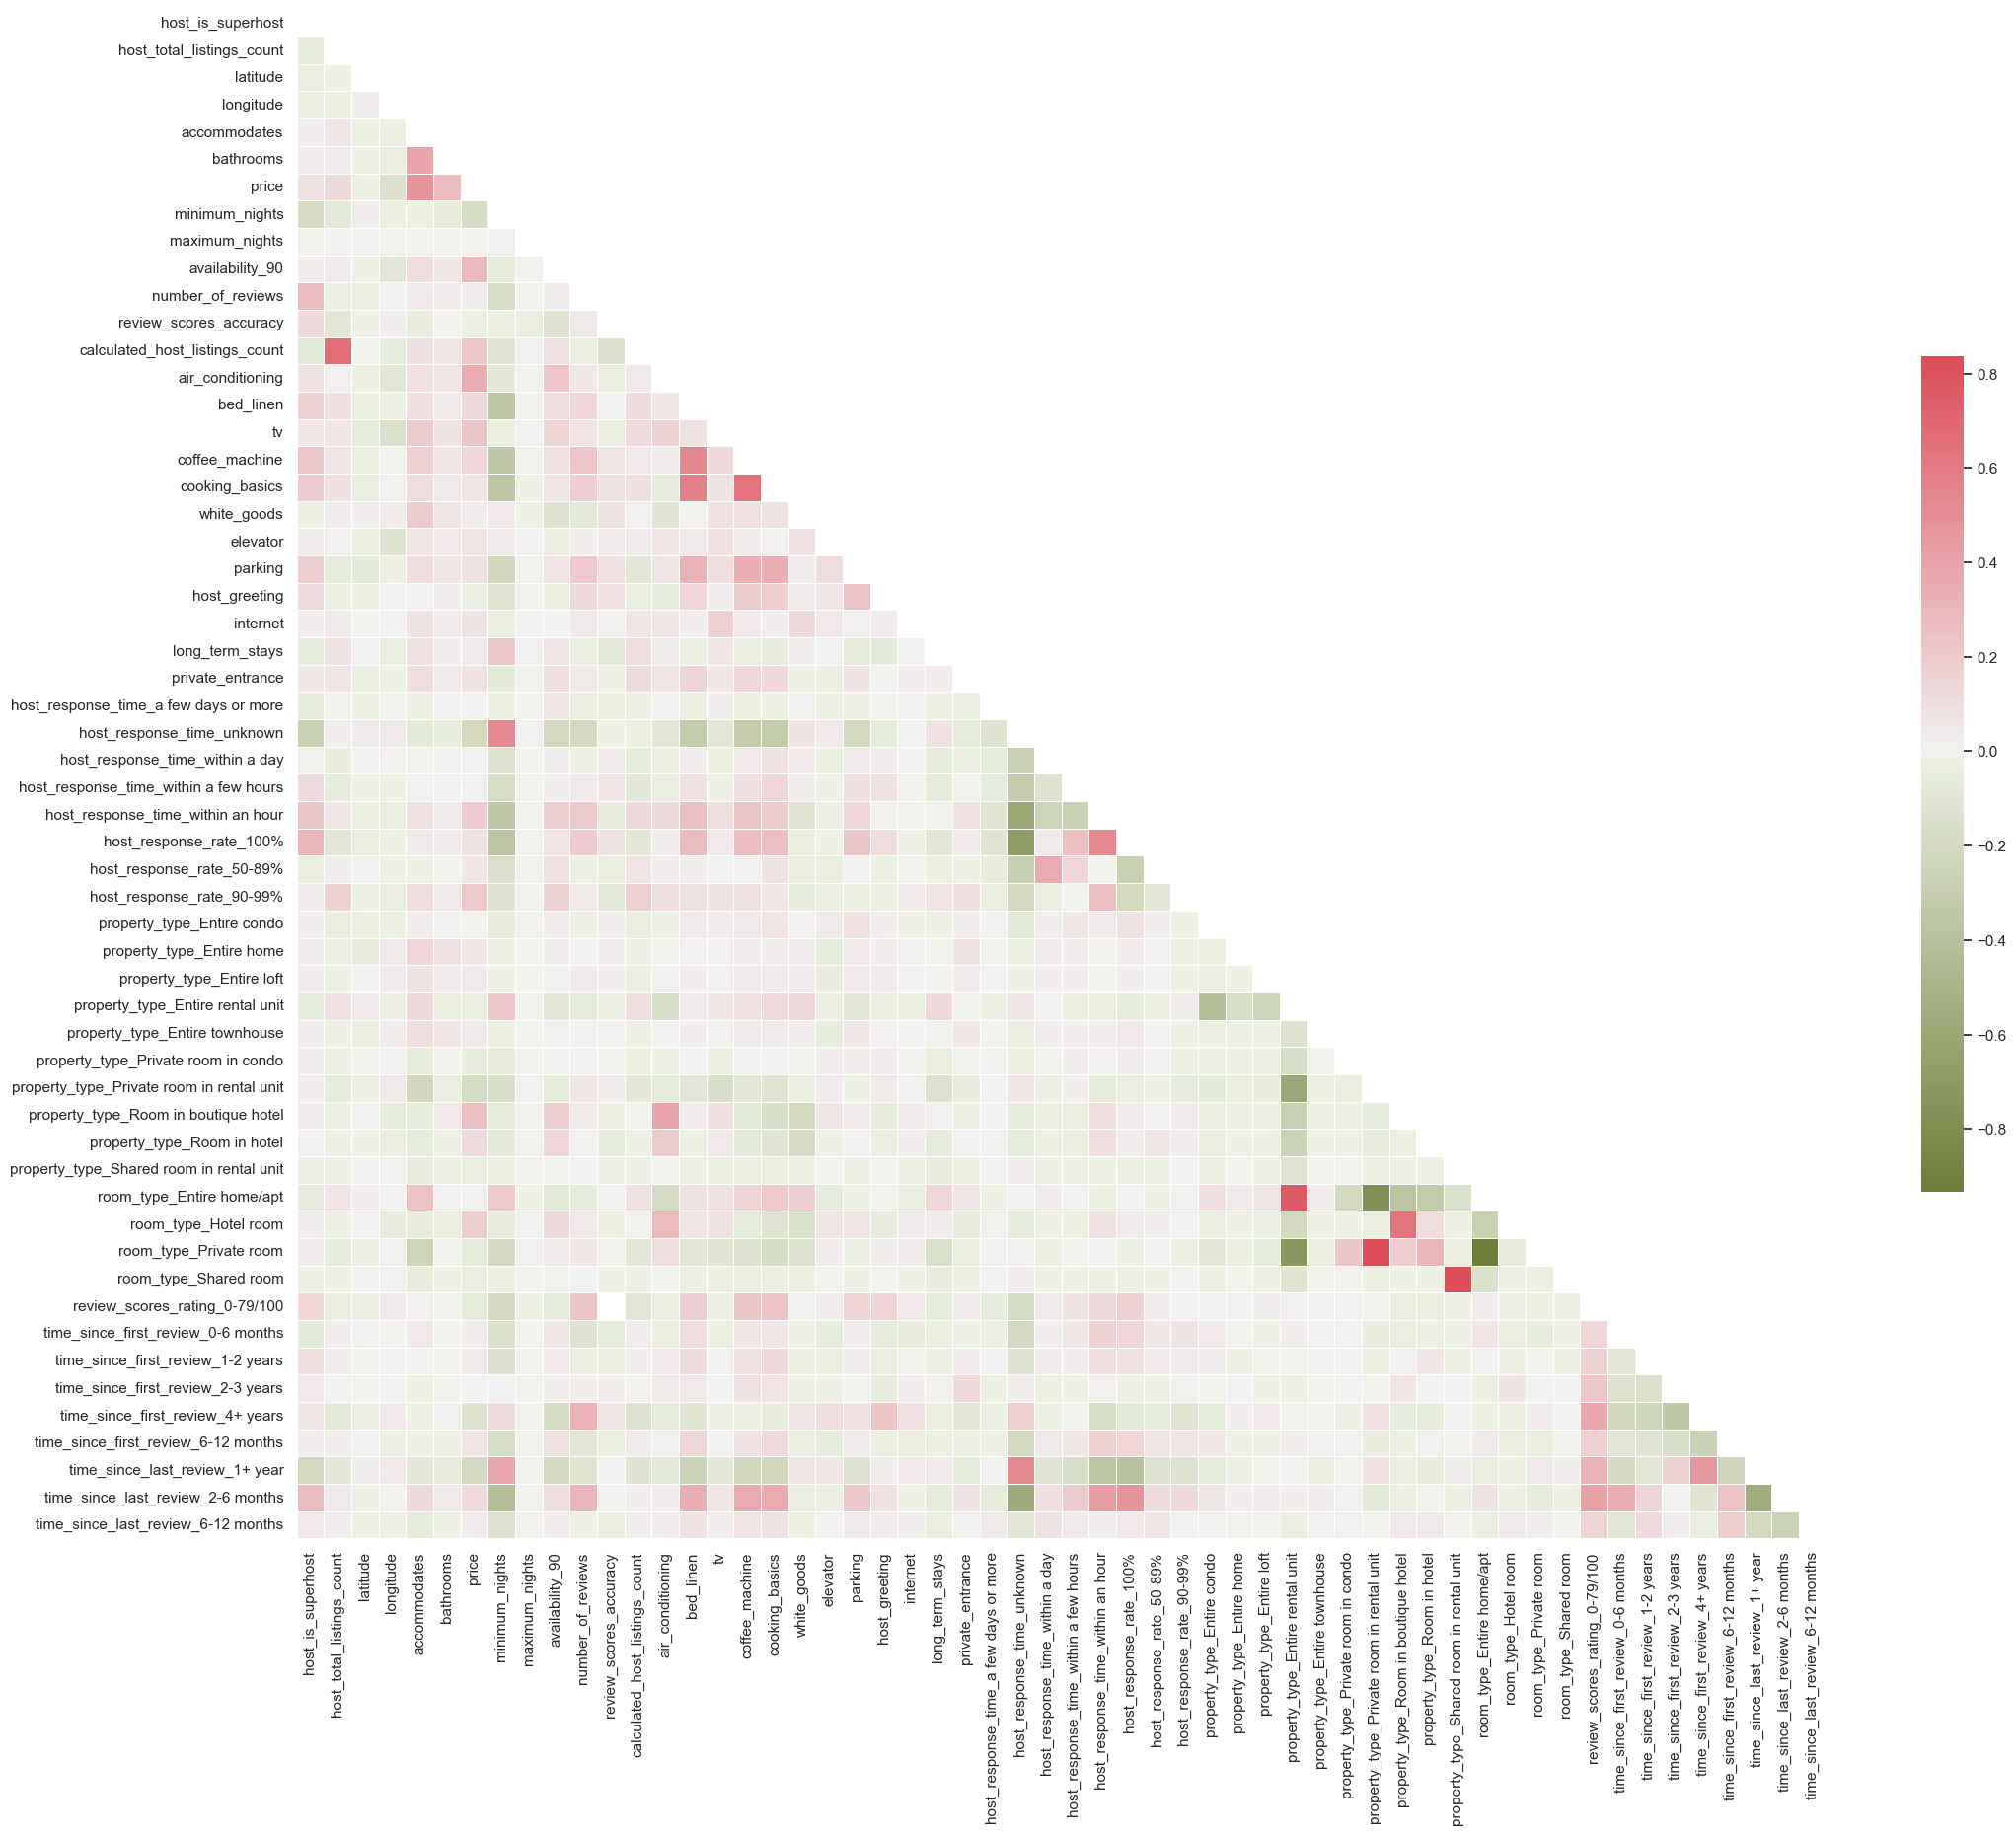

In [27]:
hm_df = df_.drop(list(df_.columns[df_.columns.str.startswith('neighbourhood')]) +
                 ['beds', 'bedrooms', 'host_response_rate_unknown','host_response_rate_0-49%'] +
                 list(df_.columns[df_.columns.str.endswith('nan')]), axis=1)
multi_collinearity_heatmap(hm_df, figsize=(25, 22))

There are some correlated features left, but we will leave as it is.

### Scale data
Now, since we encoded all categorical features, removed Null values, the next step before fiting the model is to scale all data to get better numerical stability during learning.

In [11]:
hm_df = df_.drop(list(df_.columns[df_.columns.str.startswith('neighbourhood')]) +
                 ['beds', 'bedrooms', 'host_response_rate_unknown','host_response_rate_0-49%'] +
                 list(df_.columns[df_.columns.str.endswith('nan')]), axis=1)
X = hm_df.drop(columns=["price"])
y = hm_df[["price"]]

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X = pd.DataFrame(feature_scaler.fit_transform(X), columns=list(X.columns))
y = target_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [12]:
sorted(X_train.columns)

['accommodates',
 'air_conditioning',
 'availability_90',
 'bathrooms',
 'bed_linen',
 'calculated_host_listings_count',
 'coffee_machine',
 'cooking_basics',
 'elevator',
 'host_greeting',
 'host_is_superhost',
 'host_response_rate_100%',
 'host_response_rate_50-89%',
 'host_response_rate_90-99%',
 'host_response_time_a few days or more',
 'host_response_time_unknown',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_total_listings_count',
 'internet',
 'latitude',
 'long_term_stays',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'number_of_reviews',
 'parking',
 'private_entrance',
 'property_type_Entire condo',
 'property_type_Entire home',
 'property_type_Entire loft',
 'property_type_Entire rental unit',
 'property_type_Entire townhouse',
 'property_type_Private room in condo',
 'property_type_Private room in rental unit',
 'property_type_Room in boutique hotel',
 'property_type_Room in hotel',
 'prop

Save scalers to the file so that we can easily upload them to backend for further implementation.

In [13]:
dump(target_scaler, open("../trained_objects/target_scaler.pkl", "wb"))
dump(feature_scaler, open("../trained_objects/feature_scaler.pkl", "wb"))

In [14]:
loaded_scaler = load(open('../trained_objects/target_scaler.pkl', 'rb'))

In [15]:
target_scaler.scale_ == loaded_scaler.scale_

array([ True])

## It is time to create a model!
What we have done so far:
- conducted extensive EDA
- removed or processed correlated or unnecessary features
- encoded categorical features using one hot encoding
- split our dataset to train and test subsets
- scaled them both

Now everything is ready to create the first model to predict our target variable: **price per night** for a listing.

### What model baseline to choose?
In machine learning for regression task two most efficient architectures are RandomForestClassifier and Gradient Boosting. Gradient boosting algorithms are considered to be the best predicting models.

In [17]:
# scaled x and y

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
train_preds_xgb = xgb_model.predict(X_train)
val_preds_xgb = xgb_model.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, train_preds_xgb), 4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb), 4))

print("\nTraining RMSE:", round(mean_squared_error(y_train, train_preds_xgb, squared=False), 4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb, squared=False), 4))

print("\nTraining r2:", round(r2_score(y_train, train_preds_xgb), 4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb), 4))

xgb_model.save_model("airbnb_predictor.json")


Training MSE: 0.1532
Validation MSE: 0.2789

Training RMSE: 0.3915
Validation RMSE: 0.5282

Training r2: 0.8491
Validation r2: 0.7076


In [38]:
sorted(xgb_model.feature_names_in_)

['accommodates',
 'air_conditioning',
 'availability_90',
 'bathrooms',
 'bed_linen',
 'calculated_host_listings_count',
 'coffee_machine',
 'cooking_basics',
 'elevator',
 'host_greeting',
 'host_is_superhost',
 'host_response_rate_100%',
 'host_response_rate_50-89%',
 'host_response_rate_90-99%',
 'host_response_time_a few days or more',
 'host_response_time_unknown',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_total_listings_count',
 'internet',
 'latitude',
 'long_term_stays',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'number_of_reviews',
 'parking',
 'private_entrance',
 'property_type_Entire condo',
 'property_type_Entire home',
 'property_type_Entire loft',
 'property_type_Entire rental unit',
 'property_type_Entire townhouse',
 'property_type_Private room in condo',
 'property_type_Private room in rental unit',
 'property_type_Room in boutique hotel',
 'property_type_Room in hotel',
 'prop

In [55]:
def _predict(obj: pd.DataFrame,
             model_name="airbnb_predictor.json",
             target_scaler_name="target_scaler.pkl") -> float:
    """
    :param obj: object with features prepared for prediction
    :param model_name: name of file containing pretrained model
    :param target_scaler_name: name of file containing pretrained target scaler
    :return: float model price prediction
    """
    target_scaler_ = load(open(target_scaler_name, 'rb'))
    model = XGBRegressor()
    model.load_model(model_name)
    result = round(abs(model.predict(obj) * target_scaler_.scale_)[0])
    return result

In [43]:
X_train.sample()

,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bathrooms,minimum_nights,maximum_nights,availability_90,number_of_reviews,...,room_type_Shared room,review_scores_rating_0-79/100,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_6-12 months
978,-0.377859,-0.189354,0.014396,0.055638,-0.657905,-0.19785,-0.342571,-0.018619,0.011372,0.399614,...,-0.060444,0.484811,-0.291136,-0.319607,-0.44693,1.323089,-0.349437,-0.660781,1.17694,-0.307734


In [51]:
_predict(X_test.sample())

112

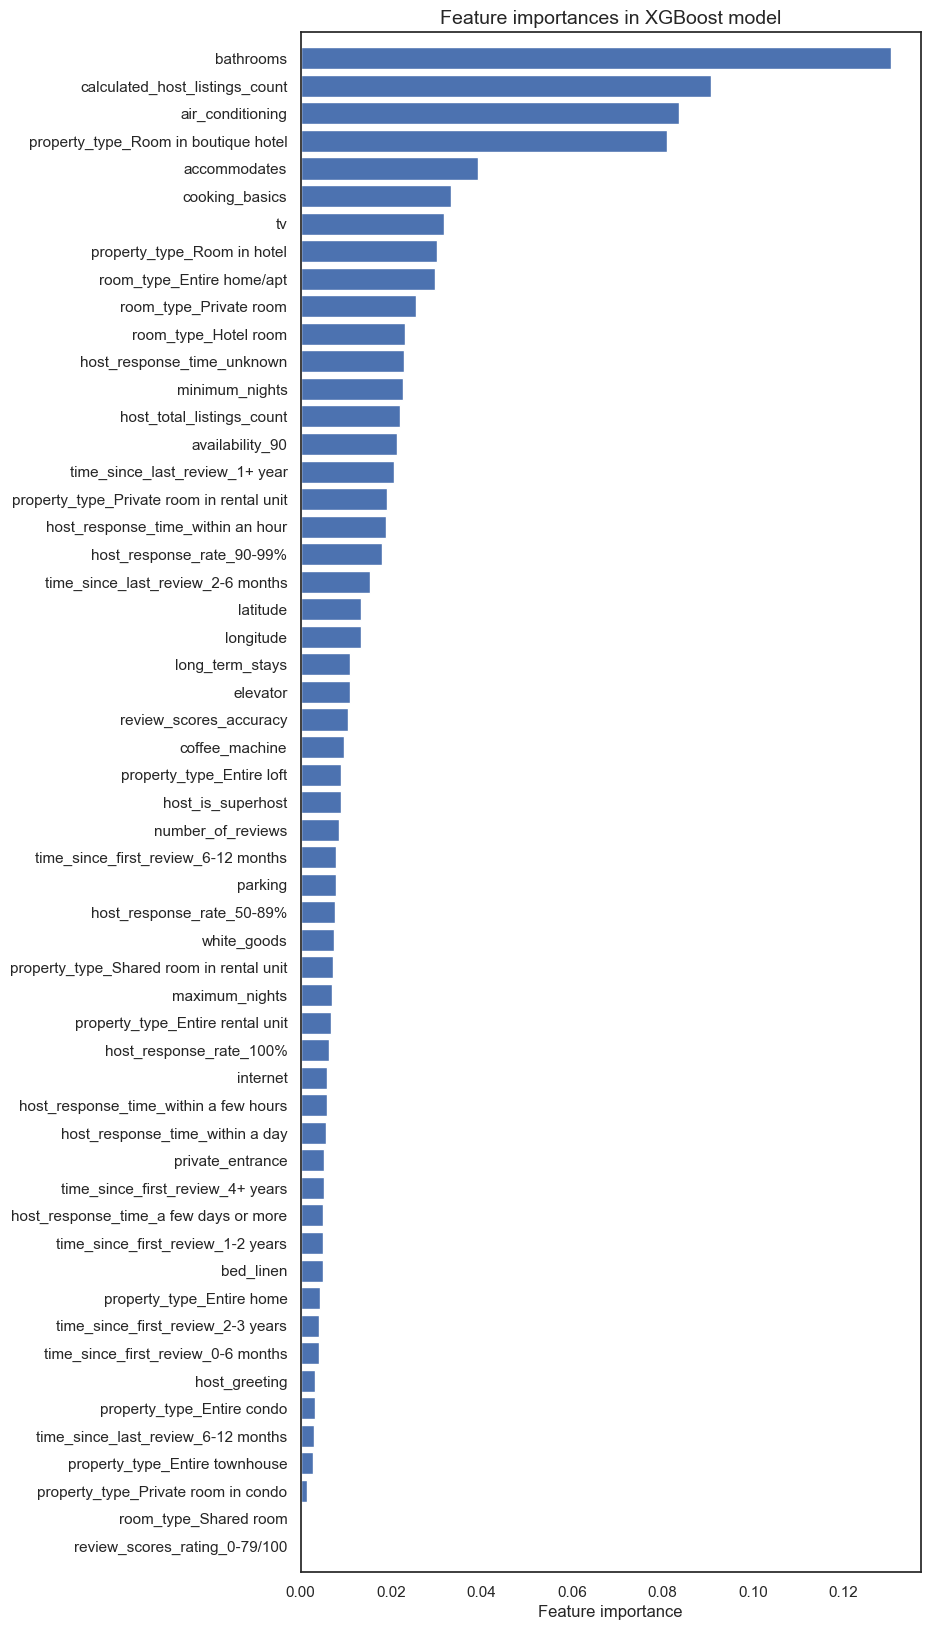

In [53]:
ft_weights_xgb_reg = pd.DataFrame(xgb_model.feature_importances_, 
                                  columns=['weight'], 
                                  index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importance in XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [54]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)